<a href="https://colab.research.google.com/github/ps1303/Project/blob/main/Support_Vector_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# APL405: Support Vector Machines

In this practical, you will implement SVMs for classification using *scikit learn* package.

**INSTRUCTIONS: The tasks to complete will appear in bold. You should try to replicate the plots by writing/filling in the code.**

Support vector machines (SVMs) are quite powerful and flexible class of supervised algorithms that can be used for both classification and regression.
In this section, we will develop the intuition behind support vector machines and their use in classification problems.



We begin with the standard imports:

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

# Generate data for linearly separable case

First we generate some binary classification data with two-dimensional input space

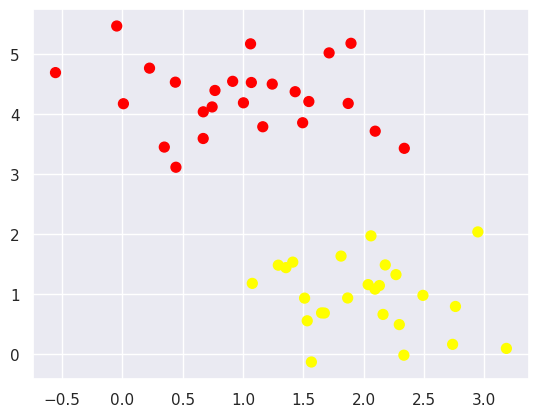

In [3]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

A linear classifier would attempt to draw a straight line (decision boundary) separating the two classes of data, and thereby create a model for linear classification.

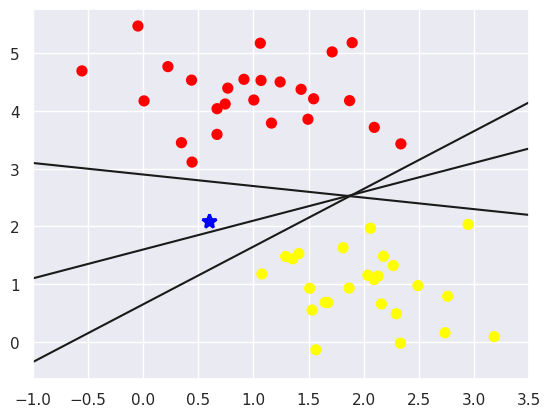

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], '*', color='blue', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

The three *very* different lines perfectly separate the two classes of samples.
Depending on which you choose, a new data point (e.g., the one marked by $⋆$ in this plot) will be assigned a different label!

Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

## Motivating Support Vector Machines

At the heart of SVM classifier design is the notion of the **margin**. The decision boundary of a linear classifier could be written as:
\begin{align}
  \underline \theta^T \underline x + \theta_0 = 0
\end{align}
Here, $\theta_0$ represents the "bias" term corresponding to an input of ones.

The margin is the region between the two *parallel* hyperplanes:
\begin{align}
  \underline \theta^T \underline x + \theta_0 & = 1 \\
  \underline \theta^T \underline x + \theta_0 & = -1
\end{align}

The idea is that the decision boundary should be “placed” between the highly populated areas of the two classes and in a region that is sparse in data, leaving the largest possible margin.  A large margin leads to good generalization performance. That is, the classifier may exhibit good test accuracy when it is faced with data outside the training set.

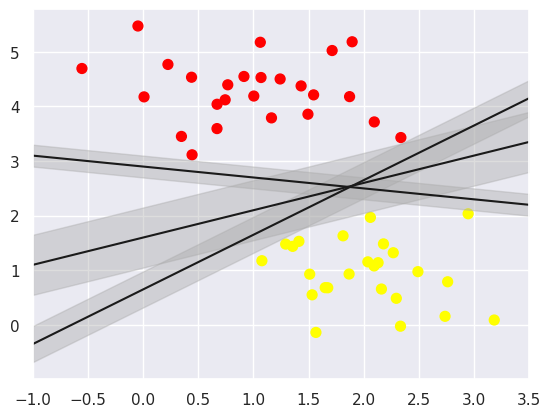

In [5]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

## Support Vector Machines: Maximizing the *Margin*

Support vector machines offer one way to improve on this.
The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a *margin* of some width, up to the nearest point.

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model.
Support vector machines are an example of such a *maximum margin* estimator.

### Fitting a support vector machine

You will be using support vector classifier ``SVC`` from [scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) to train a SVM model. A (strictly positive) regularization parameter ``C`` is used to control the $L_2$-regularizing effect. The strength of the regularization is inversely proportional to ``C``.

**TASK: Use a linear kernel and set the regularization parameter ``C`` to a very large number, say, 1E10. Plot the data along with decision boundary and the margins and the support vectors encircled.**

Recall that a linear kernel does not add any extra features, unlike say RBF or polynomial kernel.

In [6]:
# Import libraries for SVC and fit the SVM model
from sklearn.svm import SVC
model = SVC(kernel='linear', C=1e10)
model.fit(X, y)
model

SVC(C=10000000000.0, kernel='linear')

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

In [9]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)

    # Create a meshgrid using y and x to get X and Y
    YY, XX = np.meshgrid(y, x)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    P = model.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none', edgecolors = 'k');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

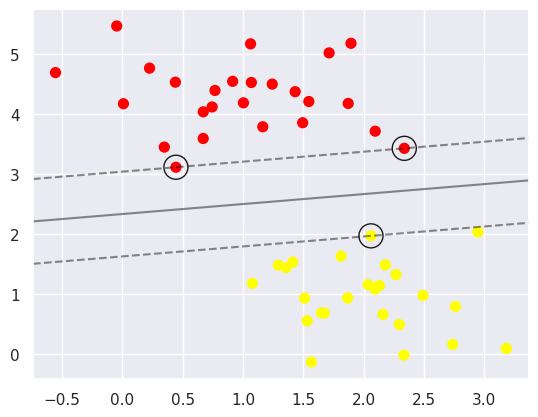

In [10]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

This is the dividing line that maximizes the margin between the two sets of points.
Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure.
These points are the pivotal elements of this fit, and are known as the *support vectors*, and give the algorithm its name.

In Scikit-Learn, the coordinates of the support vectors are stored in the ``support_vectors_`` attribute of the classifier.

**TASK: Print out the coordinates of the support vector and the non-zero components of the dual vector**

In [11]:
# print out the coordinates of the support vector
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

The support vectors correspond to the non-zero components of the dual parameter vector. The corresponding non-zero dual coefficients are stored in the ``dual_coef_`` attribute of the classifier

In [12]:
# print out the non-zero components of the dual vector
model.dual_coef_

array([[-0.2738502 , -0.75147416,  1.02532437]])

In SVM, the fit of the function only depends on the position of the support vectors; any points further from the margin which are on the correct side do not modify the fit!
Technically, this is because these points do not contribute to the (hinge) loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

In the left panel, we see the model and the support vectors for 60 training points.
In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors from the left panel are still the support vectors from the right panel.
This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

### Beyond linear boundaries: Kernel SVM

The real power of SVM shows when it is combined with *nonlinear kernels*.
Non-linear kernels *lift* the original input space to a high-dimensional feature space, often defined by polynomials and Gaussian basis functions, and thereby were able to fit for nonlinear relationships with a linear classifier in the high-dimensional feature space.

To motivate the need for kernels, let's look at some data that is not linearly separable in the original input space.

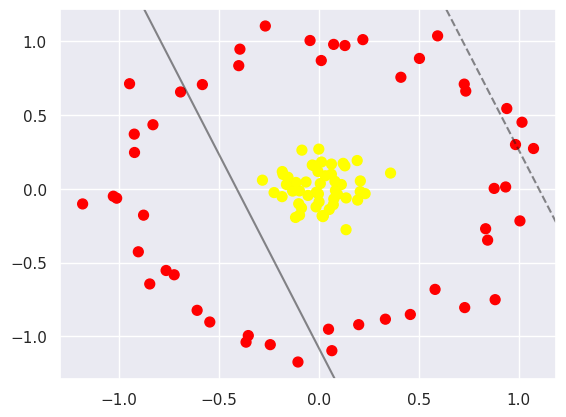

In [19]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

model2 = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model2, plot_support=False);

It is clear that no linear decision boundary will *ever* be able to separate this data.

Let us use a nonlinear *squared exponential kernel* (aka RBF kernel)
\begin{align}
r^{(i)} = \exp \left( -||\underline x^{(i)}-\underline c ||_2^2 \right)
\end{align}

**Write out the expression of RBF kernel**

In [20]:
# Calculate the value of r^(i) for all points in X using the center c = [0,0]
r = np.exp(-np.linalg.norm(X - [0, 0], axis=1)**2)

We can visualize this extra data dimension using a three-dimensional plot by plotting the coordinates and r value

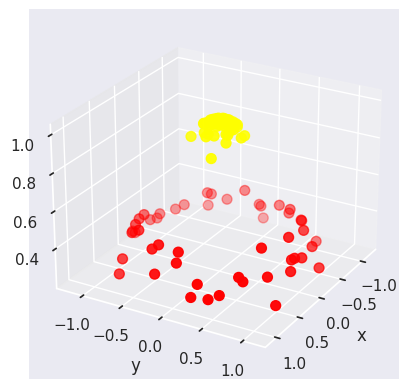

In [21]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

plot_3D(elev = 25, azim=30)


By adding this extra dimension, the data now becomes linearly separable, by drawing a separating plane at a certain height.

Here, we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results.

We would want the SVM algorithm automatically choose the center of the kernel to help separate the classes in higher dimension.

In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to, say, an RBF (radial basis function) kernel, using the ``kernel`` model hyperparameter.

**TASK: Create model3 using SVC with RBF kernel and C = 1E6. Then plot the SVC decision function for model3**


In [22]:
# Create model3 with RBF kernel and C = 1E6 and fit the X, y data
model3 = SVC(kernel='rbf', C=1E6)
model3.fit(X, y)

SVC(C=1000000.0)

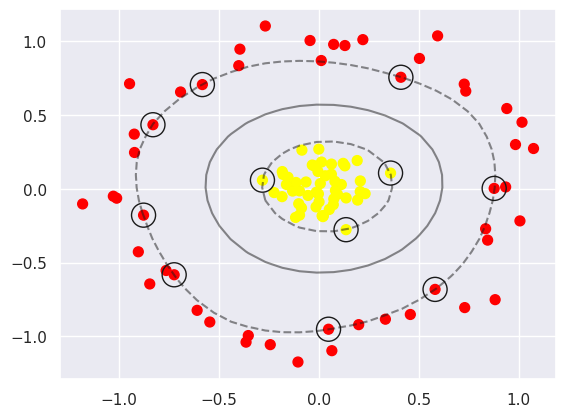

In [25]:
# Scatterplot the input and output data, plot the svc_decision_function, and encircle the support vectors
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model3)


Using this kernelized SVM, you learn a suitable nonlinear decision boundary in the original input space.

### Soft-margin SVM and tuning the regularization parameter

Our discussion thus far has centered around very clean datasets, in which a perfect decision boundary exists and SVM divided the two classes perfectly.
But what if our data has some amount of overlap among the two classes?
For example, we may have data like this:

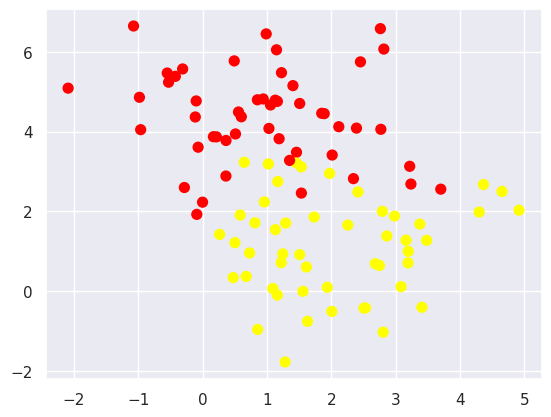

In [26]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

To handle this case, the SVM implementation has a bit of a fudge-factor which "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit.
The hardness of the margin is controlled by a tuning parameter, most often known as $C$.
For very large $C$, the margin is hard, and points cannot lie in it.
For smaller $C$, the margin is softer, and can grow to encompass some points.

**TASK: Plot a subplot with three figures showing the decision boundary, margins, and encircled support vectors for three different choice of regularization parameter ``C`` = 10.0, 0.1, 0.01**

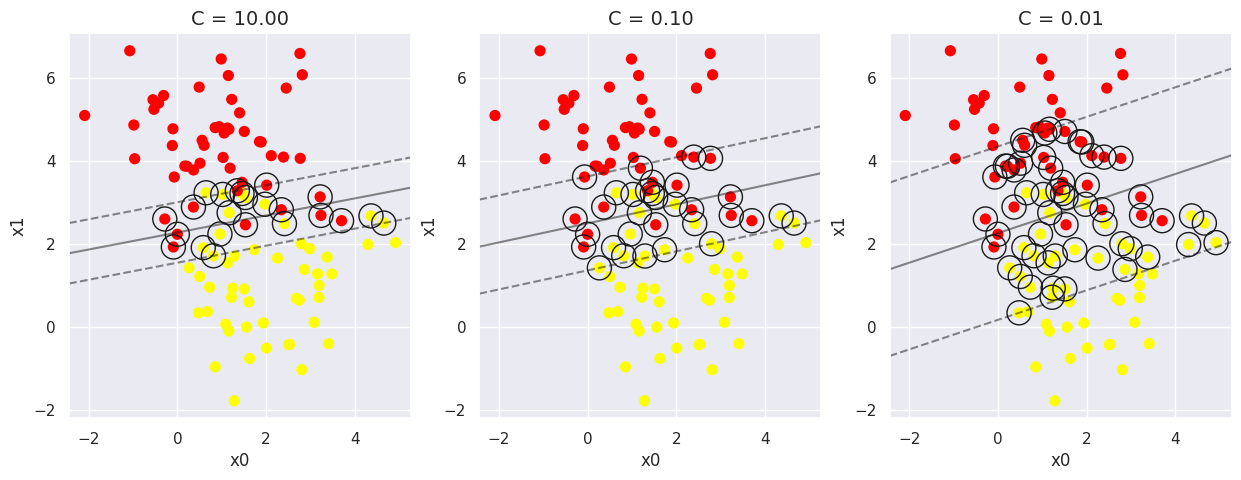

In [30]:
# Write your code here
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, C in enumerate([10.0, 0.1, 0.01]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axes[i].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, ax=axes[i])
    axes[i].set_title('C = {:.2f}'.format(C), size=14)
    axes[i].set_xlabel('x0', fontsize=12)
    axes[i].set_ylabel('x1', fontsize=12)
plt.show()

The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using cross-validation.

## Support Vector Machine Summary

We have seen here a brief intuitive introduction to the principals behind support vector machines.
These methods are a powerful classification method for a number of reasons:

- The support vectors correspond to the non-zero components of the dual parameter.
- SVM's dependence on relatively few support vectors means that they can be stored quite easily with little memory.
- Once the model is trained, the prediction phase is very fast, because the classification of new points are affected only by support vectors (or points on or inside the margins)

However, SVMs have several disadvantages as well:

- The scaling with the number of samples $N$ is $\mathcal{O}[N^3]$ at worst, or $\mathcal{O}[N^2]$ for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
- The results are strongly dependent on a suitable choice for the softening parameter $C$. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
- The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (see the ``probability`` parameter of ``SVC``), but this extra estimation is costly.

With those traits in mind, one usually turns to SVMs only when other simpler, faster, and less tuning-intensive methods have been shown to be insufficient for one's needs.
Nevertheless, if you have the CPU cycles to commit to training and cross-validating an SVM on your data, the method can lead to excellent results.